In [661]:
library(randomForestSRC)
library(CoxHD)
library(Hmisc)
library(gridExtra)
library("survminer")
library(dplyr)
library(stringr)
library(survminer)
library(tidyr)
library(cmprsk)
options(warn=-1)
source("../../../src/tools.R")
source("../../script_figures/tools.R")

library(mstate)
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 250, # set the maximum number of rows displayed
        repr.matrix.max.cols = 250) # set the maximum number of columns displayed

# Initial Data

In [800]:
df <- read.table('../../clustering/clustering_Final_1/df_final_full_component.tsv')
comp <- colnames(df)[170:185]
master <- read.table('../../../data/initial_dataset/Master_04_10_2019.csv',sep=",",header=T)
rownames(master) <- master$data_pd
tmp <- merge(df[,c(comp,"final_component")],master,by=0)
rownames(tmp) <- tmp$Row.names
tmp$patient_id <- tmp$Row.names

# Classic Model

In [663]:
# Remove weird cases (11) : we do not know when they have relapsed or CR


tmp <- tmp[!(tmp$RelapseCIStatus==1 & !is.na(tmp$RelapseCIStatus) & is.na(tmp$OS_CR)),]
tmp <- tmp[!(tmp$RelapseCIStatus==1 & !is.na(tmp$RelapseCIStatus) & tmp$os_status==1 & tmp$RFSyears > tmp$OS_CR),]   # you can not relapse from CR  after you die !!!
tmp <- tmp[!(tmp$RFSyears==0 & !is.na(tmp$RFSyears)),]  ### remove when Relapse is exactly 0!


# Handle CR

tmp$CR_stat <- ifelse(is.na(tmp$OS_CR),0,1)
tmp[is.na(tmp$OS_CR),"CR"] <- tmp[is.na(tmp$OS_CR),"os"]
tmp[!is.na(tmp$OS_CR),"CR"]<- tmp[!is.na(tmp$OS_CR),"os"] - tmp[!is.na(tmp$OS_CR),"OS_CR"]

# Handle RFS (relapse from first CR)

tmp$Relapse_stat <- ifelse(tmp$RelapseCIStatus==1 & !is.na(tmp$RelapseCIStatus),1,0)
tmp$Relapse <- tmp$os
tmp[tmp$Relapse_stat==1,"Relapse"] <- tmp[tmp$Relapse_stat==1,"CR"] + tmp[tmp$Relapse_stat==1,"RFSyears"]

tmp$OS <- tmp$os
tmp$OS_stat <- tmp$os_status



# Advanced Model

In [813]:
# Remove weird cases (11) : we do not know when they have relapsed or CR


tmp <- tmp[!(tmp$RelapseCIStatus==1 & !is.na(tmp$RelapseCIStatus) & is.na(tmp$OS_CR)),]
tmp <- tmp[!(tmp$RelapseCIStatus==1 & !is.na(tmp$RelapseCIStatus) & tmp$os_status==1 & tmp$RFSyears > tmp$OS_CR),]   # you can not relapse from CR  after you die !!!
tmp <- tmp[!(tmp$RFSyears==0 & !is.na(tmp$RFSyears)),]  ### remove when Relapse is exactly 0!


# Handle CR

tmp$CR_stat <- ifelse(is.na(tmp$OS_CR),0,1)
tmp[is.na(tmp$OS_CR),"CR"] <- tmp[is.na(tmp$OS_CR),"os"]
tmp[!is.na(tmp$OS_CR),"CR"]<- tmp[!is.na(tmp$OS_CR),"os"] - tmp[!is.na(tmp$OS_CR),"OS_CR"]

# Handle RFS (relapse from first CR)

tmp$Relapse_stat <- ifelse(tmp$RelapseCIStatus==1 & !is.na(tmp$RelapseCIStatus),1,0)
tmp$Relapse <- tmp$os
tmp[tmp$Relapse_stat==1,"Relapse"] <- tmp[tmp$Relapse_stat==1,"CR"] + tmp[tmp$Relapse_stat==1,"RFSyears"]

tmp$OS <- tmp$os
tmp$OS_stat <- tmp$os_status

tmp$Death_in_CR <- tmp$OS
tmp$Death_in_CR_stat <- ifelse(tmp$CR_stat==1 & tmp$Relapse_stat==0 & tmp$OS_stat==1,1,0 )

tmp$Death_in_CR <- tmp$OS
tmp$Death_in_CR_stat <- ifelse(tmp$CR_stat==1 & tmp$Relapse_stat==0 & tmp$OS_stat==1,1,0 )

tmp$Death_in_Relapse <- tmp$OS
tmp$Death_in_Relapse_stat <- ifelse(tmp$CR_stat==1 & tmp$Relapse_stat==1 & tmp$OS_stat==1,1,0 )

tmp$Death_without <- tmp$OS
tmp$Death_without_stat <- ifelse(tmp$CR_stat==0 & tmp$Relapse_stat==0 & tmp$OS_stat==1,1,0 )



In [814]:
# data <- tmp[,c("patient_id","CR","Relapse","OS","CR_stat","Relapse_stat","OS_stat",comp,"final_component")]
data <- tmp[,c("patient_id","CR","Relapse","Death_in_CR","Death_in_Relapse","Death_without","CR_stat","Relapse_stat","Death_in_CR_stat","Death_in_Relapse_stat","Death_without_stat",comp,"final_component")]
head(data)

,patient_id,CR,Relapse,Death_in_CR,Death_in_Relapse,Death_without,CR_stat,Relapse_stat,Death_in_CR_stat,Death_in_Relapse_stat,Death_without_stat,full_component_t_15_17,full_component_inv_16,full_component_t_8_21,full_component_t_11,full_component_t_6_9,full_component_inv_3,full_component_additions,full_component_TP53_complex,full_component_NPM1,full_component_CEBPA_bi,full_component_DNMT3A_IDH1_2,full_component_WT1,full_component_chr_splicing_multiple,full_component_chr_splicing_1,full_component_not_assigned,full_component_no_events,final_component
PD14868a,PD14868a,0.19164956,0.19164956,0.19164956,0.19164956,0.19164956,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,NPM1
PD14869c,PD14869c,0.09308693,4.70636550,4.70636550,4.70636550,4.70636550,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,t_11
PD14871a,PD14871a,0.16427105,0.33687379,0.37782341,0.37782341,0.37782341,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,NPM1
PD14872a,PD14872a,0.04928131,0.04928131,0.04928131,0.04928131,0.04928131,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,TP53_complex
PD14873a,PD14873a,0.55030801,0.55030801,0.55030801,0.55030801,0.55030801,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,chr_splicing_multiple
PD14874a,PD14874a,0.20807666,0.20807666,0.20807666,0.20807666,0.20807666,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,chr_splicing_multiple


# Creation of transition matrix  (irreversible acyclic Markov Chain)

In [815]:
tmat_data <- transMat(x = list(c(2,4), c(3, 4), c(4), c()), names = c("Alive", "CR", "Relapse", "Death"))
tmat_data <- transMat(x = list(c(2,6), c(3, 4), c(5), c(),c(),c()), names = c("Alive", "Alive in CR", "Alive with Relapse", "Death in CR" ,"Death in Relapse", "Death without CR"))
tmat_data

,Alive,Alive in CR,Alive with Relapse,Death in CR,Death in Relapse,Death without CR
Alive,NA,1,NA,NA,NA,2
Alive in CR,NA,NA,3,4,NA,NA
Alive with Relapse,NA,NA,NA,NA,5,NA
Death in CR,NA,NA,NA,NA,NA,NA
Death in Relapse,NA,NA,NA,NA,NA,NA
Death without CR,NA,NA,NA,NA,NA,NA


In [816]:
# All Possible Paths through the multistate model
paths(tmat_data)

1,NA,NA,NA
1,2,NA,NA
1,2,3,NA
1,2,3,5
1,2,4,NA
1,6,NA,NA


In [817]:
msdata <- msprep(data = data, trans = tmat_data, time = c(NA, "CR", "Relapse",
"Death_in_CR","Death_in_Relapse","Death_without"), status = c(NA, "CR_stat", "Relapse_stat", "Death_in_CR_stat","Death_in_Relapse_stat","Death_without_stat"),keep=c("patient_id","final_component"))

# Summary of Transition States

In [818]:
events(msdata)

$Frequencies
                    to
from                 Alive Alive in CR Alive with Relapse Death in CR
  Alive                  0        1464                  0           0
  Alive in CR            0           0                755         182
  Alive with Relapse     0           0                  0           0
  Death in CR            0           0                  0           0
  Death in Relapse       0           0                  0           0
  Death without CR       0           0                  0           0
                    to
from                 Death in Relapse Death without CR no event total entering
  Alive                             0              591       55           2110
  Alive in CR                       0                0      527           1464
  Alive with Relapse              582                0      173            755
  Death in CR                       0                0      182            182
  Death in Relapse                  0                0  

# Expand Covariates 

In [819]:
# msdata <- expand.covs(msdata, comp, longnames = FALSE)

# Non Parametric Models

In [820]:
c0_data <- coxph(Surv(Tstart, Tstop, status) ~ strata(trans), data = msdata,method="breslow")

In [821]:
c0_data

Call:  coxph(formula = Surv(Tstart, Tstop, status) ~ strata(trans), 
    data = msdata, method = "breslow")

Null model
  log likelihood= -23235.22 
  n= 7903 

In [822]:
msf0_data <- msfit(object = c0_data,newdata=msdata,trans=tmat_data)

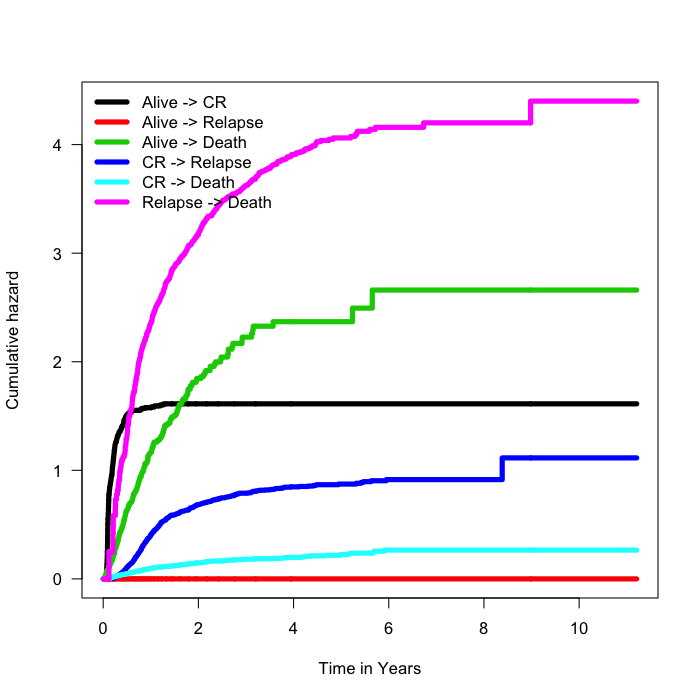

In [794]:
plot(msf0_data, las = 1,lty=rep(1,6),xlab = "Time in Years",lwd=5)

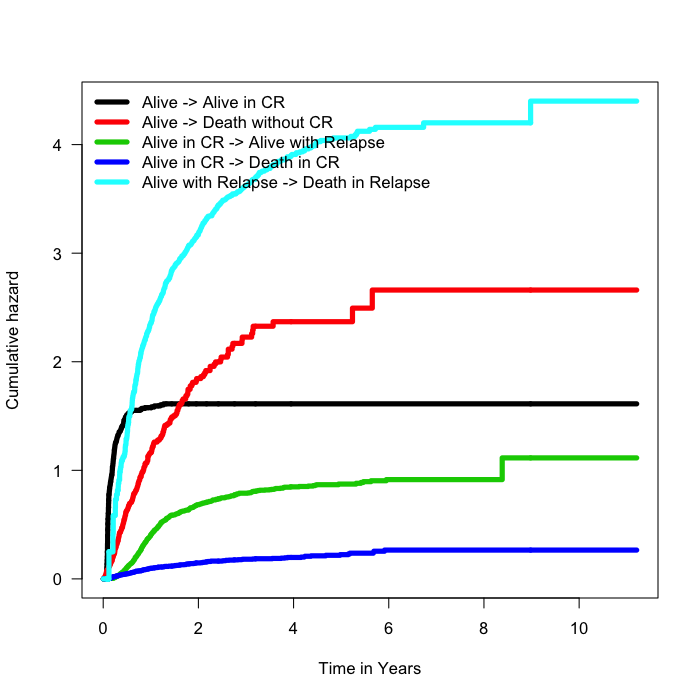

In [823]:
plot(msf0_data, las = 1,lty=rep(1,6),xlab = "Time in Years",lwd=5)

# Transition Probability Estimates : Aalen–Johansen estimator for transition probability matrix of a Markov process with a finite number of states

In [824]:
pt0_data <- probtrans(msf0_data, predt = 0, method = "greenwood",direction = "fo")

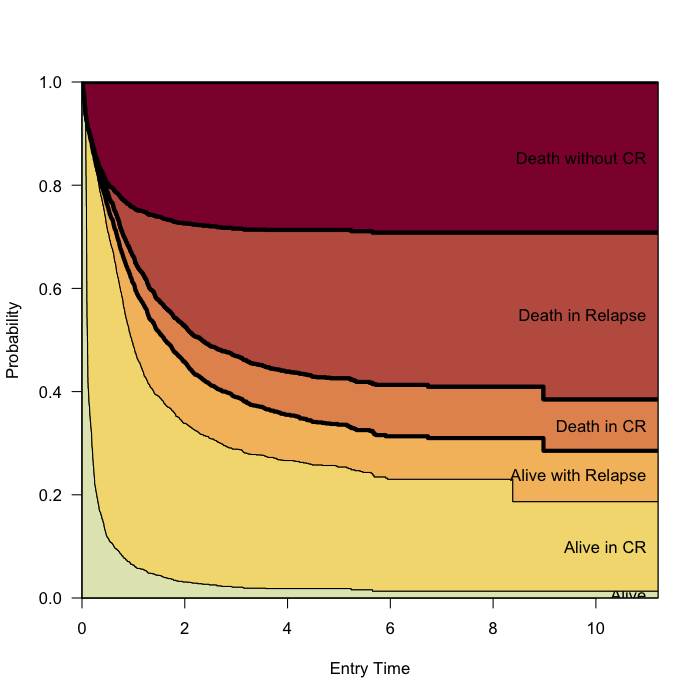

In [849]:
library("colorspace")
# pt0_data <- probtrans(msf0_data, predt = 0, method = "greenwood",direction = "fo")
statecols <- heat_hcl(6, c = c(80, 30), l = c(30, 90),power = c(1/5, 2))[c(6,5,4,3,2,1)]
ord <- c(1,2,3,4,5,6)
plot(pt0_data,from=1, ord = ord, xlab = "Entry Time",las = 1, type = "filled", col = statecols[ord],lty=c(2,2,2,2,2,2),lwd=c(1,1,1,4,4,4,1,1,1))

# Semi-parametric Models : Introduction of the covariates